## 基于同义词词典的方法

在同义词词典中，具有相同含义的单词（同义词）或含义类似的单词（近义词）被归类到同一个组中。

另外，在自然语言处理中用到的同义词词典有时会定义单词之间的粒度更细的关系，比如“上位 - 下位”关系、“整体 - 部分”关系。

通过对所有单词创建近义词集合，并用图表示各个单词的关系，可以定义单词之间的联系。

最著名的同义词词典是 WordNet。使用 WordNet，可以获得单词的近义词，或者利用单词网络。使用单词网络，可以计算单词之间的相似度。

有很多问题
+ 难以顺应时代变化
+ 人力成本高
+ 无法表达单词的微妙差异

## 基于计数的方法 

### 语料库

语料库就是大量的文本数据。不过，语料库不是胡乱收集数据，一般收集的都是用于自然语言处理研究和应用的文本数据。

语料库知识一些文本数据而已，但包含了大量的关于自然语言的实践知识，即文章的写作方法、单词的选择方法和单词含义等。

### 基于python的语料库的预处理

In [1]:
text = "You say goodbye and I say hello."
text = text.lower()
text = text.replace('.', ' .')
words = text.split(' ')
words

['you', 'say', 'goodbye', 'and', 'i', 'say', 'hello', '.']

In [2]:
word_to_id = {}
id_to_word = {}

for word in words:
    if word not in word_to_id:
        new_id = len(word_to_id)
        word_to_id[word] = new_id
        id_to_word[new_id] = word

变量id_to_word负责将单词 ID 转化为单词（键是单词 ID，值是单词），word_to_id负责将单词转化为单词 ID

In [3]:
id_to_word

{0: 'you', 1: 'say', 2: 'goodbye', 3: 'and', 4: 'i', 5: 'hello', 6: '.'}

In [4]:
word_to_id

{'.': 6, 'and': 3, 'goodbye': 2, 'hello': 5, 'i': 4, 'say': 1, 'you': 0}

In [5]:
import numpy as np
corpus = [word_to_id[w] for w in words]
corpus = np.array(corpus)
corpus

array([0, 1, 2, 3, 4, 1, 5, 6])

### 整理为语料库预处理函数

In [6]:
def preprocess(text):
    text = text.lower()
    text = text.replace('.', ' .')
    words = text.split(' ')
    
    word_to_id = {}
    id_to_word = {}
    for word in words:
        if word not in word_to_id:
            new_id = len(word_to_id)
            word_to_id[word] = new_id
            id_to_word[new_id] = word
    corpus = np.array([word_to_id[w] for w in words])
    return corpus, word_to_id, id_to_word

In [7]:
text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)

### 单词的分布式表示

使用 RGB 这样的向量表示可以更准确地指定颜色。
此外，颜色之间的关联性（是否是相似的颜色）也更容易通过向量表示来判断和量化。
在自然语言处理领域，**单词的分布式表示，将单词表示为固定长度的向量。**这种向量的特征在于它是用密集向量表示的。
**密集向量：向量的各个元素大多数由非零实数构成的。**

### 分布式假设

**分布式假设**： 某个单词的含义由它周围的单词构成。

单词本身没有含义，单词的含义由它的上下文语境形成。

上下文的大小称为**窗口大小**。此处将左右两边相同数量的单词作为上下文。

### 共现矩阵

如何基于分布式假设使用向量表示单词，最直截了当的实现方法是对周围单词的数量进行计数。具体来说，在关注某个单词的情况下，对它的周围出现了多少次什么单词进行计数，然后再汇总。

In [8]:
import sys
sys.path.append("..")
import numpy as np
from common.util import preprocess

In [9]:
text= 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)

print(corpus)
print(id_to_word)

[0 1 2 3 4 1 5 6]
{0: 'you', 1: 'say', 2: 'goodbye', 3: 'and', 4: 'i', 5: 'hello', 6: '.'}


#### 用表格汇总各个单词的上下文中包含的单词的频数 , 即共现矩阵

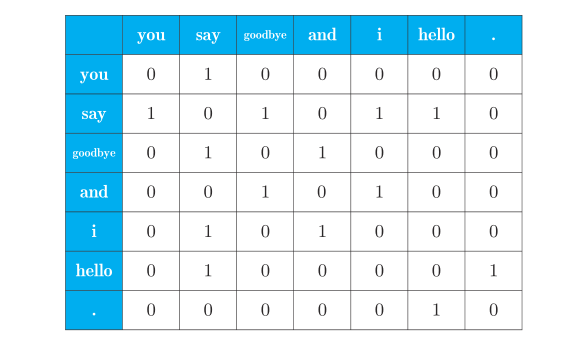

In [10]:
def create_co_matrix(corpus, vocab_size, window_size=1):
    """
    corpus : 单词ID列表
    vocab_size : 词汇个数
    window_size : 窗口大小
    """
    corpus_size = len(corpus)
    co_matrix = np.zeros((vocab_size, vocab_size), dtype=np.int32)
    
    for idx, word_id in enumerate(corpus):
        for i in range(1, window_size + 1):
            left_idx = idx - i
            right_idx = idx + i
            
            if left_idx >= 0:
                left_word_id = corpus[left_idx]
                co_matrix[word_id, left_word_id] += 1
                
            if right_idx < corpus_size:
                right_word_id = corpus[right_idx]
                co_matrix[word_id, right_word_id] += 1
                
    return co_matrix

### 向量间的相似度
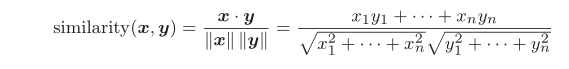

In [11]:
def cos_similarity(x, y):
    nx = x / np.sqrt(np.sum(x**2))
    ny = y / np.sqrt(np.sum(y**2))
    return np.dot(nx, ny)

为了防止分母出现零向量，从而导致除数为0的情况，可以在执行除法时加上一个微小值。

In [12]:
def cos_similarity(x, y, eps=1e-8):
    nx = x / (np.sqrt(np.sum(x**2)) + eps)
    ny = y / (np.sqrt(np.sum(y**2)) + eps)
    return np.dot(nx, ny)

In [13]:
vocab_size = len(word_to_id)
C = create_co_matrix(corpus, vocab_size)
c0 = C[word_to_id['you']]
c1 = C[word_to_id['i']]
print(cos_similarity(c0, c1))

0.707106769115


### 相似单词的排序

当某个单词被作为查询词时，将与这个查询词相似的单词按降序显示出来。

In [14]:
def most_similar(query, word_to_id, id_to_word, word_matrix, top=5):
    """
    query : 查询词
    word_to_id : 单词到单词ID的字典
    id_to_word : 单词ID到单词的字典
    word_matrix : 汇总了单词向量的矩阵， 假定保存了与各行对应的单词向量
    top : 显示到前几位
    """
    
    if query not in word_to_id:
        print('%s is not found' % query)
        return
    print('\n[query] ' + query)
    query_id = word_to_id[query]
    query_vec = word_matrix[query_id]
    
    vocab_size = len(id_to_word)
    similarity = np.zeros(vocab_size)
    for i in range(vocab_size):
        similarity[i] = cos_similarity(word_matrix[i], query_vec)
        
    count = 0
    for i in (-1 * similarity).argsort():
        if id_to_word[i] == query:
            continue
        print(' %s: %s' % (id_to_word[i], similarity[i]))
        
        count += 1
        if count >= top:
            return

In [15]:
most_similar('you', word_to_id, id_to_word, C, top=5)


[query] you
 goodbye: 0.707106769115
 i: 0.707106769115
 hello: 0.707106769115
 say: 0.0
 and: 0.0


## 基于计数方法的改进

### 点互信息 

当涉及到高频词汇时，共现矩阵不能很好地展示单词出现地信息。因为如果某个词是常用词，其他词会和这个词由很强地相关性，造成语义上的干扰。
比如，我们来考虑某个语料库中 the 和 car 共现的情况。在这种情况下，我们会看到很多“...the car...”这样的短语。因此，它们的共现次数将会很大。另外，car 和 drive 也明显有很强的相关性。但是，如果只看单词的出现次数，那么与 drive 相比，the 和 car 的相关性更强。这意味着，仅仅因为 the 是个常用词，它就被认为与 car 有很强的相关性。

#### PMI

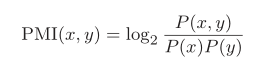

P(x) 表示 x 发生的概率，P(y) 表示 y 发生的概率，P(x, y) 表示 x和 y 同时发生的概率。PMI 的值越高，表明相关性越强。

将共现矩阵表示为 C，将单词 x 和 y 的共现次数表示为 C(x, y)，将单词 x 和 y 的出现次数分别表示为 C(x)、C(y)，将语料库的单词数量记为N，则上式可以重写为：

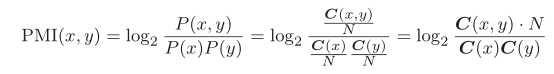

#### PPMI（正的点互信息，Positive PMI）

当两个单词的共现次数为0时，PMI为-∞。为了解决这个问题，引入正的点互信息.

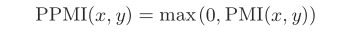

将共现矩阵转换为PPMI矩阵的函数。

为了仅从共现矩阵求 PPMI 矩阵而进行了简单的实现。具体来说，当单词 x 和 y 的共现次数为 C(x, y) 时，$C(x) = \sum_iC(i, x)),C(y) = \sum_iC(i, y),N = \sum_i \sum_jC(i, j)$，进行这样近似并实现。

In [16]:
def ppmi(C, verbose=False, eps=1e-8):
    '''生成PPMI（正的点互信息）

    :param C: 共现矩阵
    :param verbose: 是否输出进展情况
    :return:
    '''
    M = np.zeros_like(C, dtype=np.float32)
    N = np.sum(C)
    S = np.sum(C, axis=0)
    total = C.shape[0] * C.shape[1]
    cnt = 0
    
    for i in range(C.shape[0]):
        for j in range(C.shape[1]):
            pmi = np.log2(C[i, j] * N / (S[j]*S[i]) + eps)
            M[i, j] = max(0, pmi)
            
            if  verbose:
                cnt += 1
                if cnt % (total//100+1) == 0:
                    print('%.1f%% done' % (100*cnt/total))
    return M
    

In [17]:
W = ppmi(C)

np.set_printoptions(precision=3)  # 有效位数为3位
print('covariance matrix')
print(C)
print('-'*50)
print('PPMI')
print(W)

covariance matrix
[[0 1 0 0 0 0 0]
 [1 0 1 0 1 1 0]
 [0 1 0 1 0 0 0]
 [0 0 1 0 1 0 0]
 [0 1 0 1 0 0 0]
 [0 1 0 0 0 0 1]
 [0 0 0 0 0 1 0]]
--------------------------------------------------
PPMI
[[ 0.     1.807  0.     0.     0.     0.     0.   ]
 [ 1.807  0.     0.807  0.     0.807  0.807  0.   ]
 [ 0.     0.807  0.     1.807  0.     0.     0.   ]
 [ 0.     0.     1.807  0.     1.807  0.     0.   ]
 [ 0.     0.807  0.     1.807  0.     0.     0.   ]
 [ 0.     0.807  0.     0.     0.     0.     2.807]
 [ 0.     0.     0.     0.     0.     2.807  0.   ]]


### 降维

那就是随着语料库的词汇量增加，各个单词向量的维数也会增加。

并且其中很多元素都是0，说明绝大多数元素不重要。

一个常见解决方法是降维。

#### SVD（奇异值分解,Singular Value Decomposition）

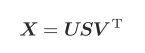

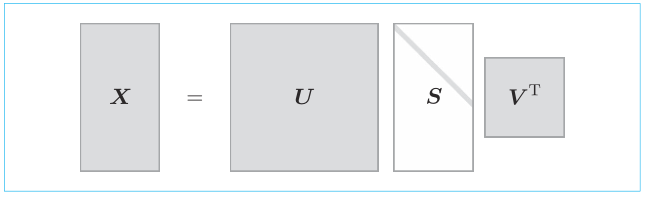

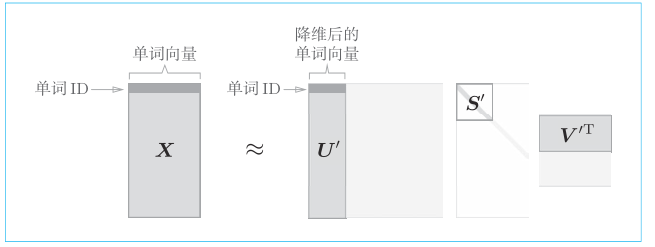

[0 1 0 0 0 0 0]
[ 0.     1.807  0.     0.     0.     0.     0.   ]
[ -3.409e-01  -1.110e-16  -3.886e-16  -1.205e-01   0.000e+00   9.323e-01
   2.226e-16]


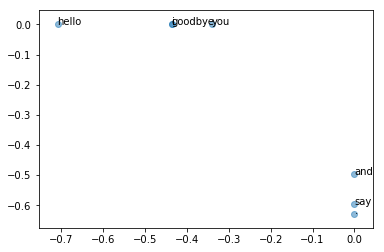

In [18]:
import matplotlib.pyplot as plt
from common.util import preprocess, create_co_matrix, ppmi

text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)
vocab_size = len(id_to_word)
C = create_co_matrix(corpus, vocab_size, window_size=1)
W = ppmi(C)


# SVD
U, S, V = np.linalg.svd(W)

np.set_printoptions(precision=3)  # 有效位数为3位
print(C[0])
print(W[0])
print(U[0])

# plot
for word, word_id in word_to_id.items():
    plt.annotate(word, (U[word_id, 0], U[word_id, 1]))
plt.scatter(U[:,0], U[:,1], alpha=0.5)
plt.show()

### PTB数据集

使用真正的语料库————Penn Treebank 语料库

与原始的PTB文章相比，多了若干预处理，将稀有单词转换成特殊字符unk，将具体的数字换成'N'等。

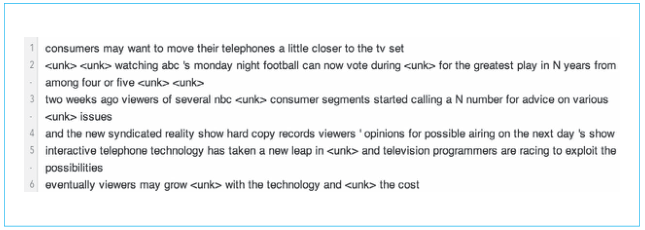

In [19]:
from dataset import ptb

corpus, word_to_id, id_to_word =  ptb.load_data('train')

print('corpus size:', len(corpus))
print('corpus[:30]:', corpus[:30])
print()
print('id_to_word[0]:', id_to_word[0])
print('id_to_word[1]:', id_to_word[1])
print('id_to_word[2]:', id_to_word[2])
print()
print("word_to_id['car']:", word_to_id['car'])
print("word_to_id['happy']:", word_to_id['happy'])
print("word_to_id['lexus']:", word_to_id['lexus'])

Done
corpus size: 929589
corpus[:30]: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29]

id_to_word[0]: aer
id_to_word[1]: banknote
id_to_word[2]: berlitz

word_to_id['car']: 3856
word_to_id['happy']: 4428
word_to_id['lexus']: 7426
